In [2]:
import pandas as pd
import qiime2 as q2
from biom import Table
import numpy as np
from biom.util import biom_open
from qiime2.plugins.phylogeny.methods import filter_table
from qiime2.plugins.mmvec.actions import paired_omics, summarize_paired
np.random.seed(42)

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [3]:
table_metag = q2.Artifact.load('../data/metaG/metaG-matched-table.qza')
metadata_metag = q2.Metadata.load('../data/metaG/metaG-matched-metadata.qza')
tree_metag = q2.Artifact.load('../data/metaG/wol_tree.qza')
table_metag = filter_table(table_metag, tree_metag).filtered_table
table_metag = table_metag.view(Table)

coverage = pd.read_csv('../data/coverage.tsv', sep='\t', index_col=0)
coverage = coverage[coverage.coverage_ratio > 0.5]


# filter and match the table
n_features, n_samples = table_metag.shape
min_feature_frequency = 0
min_feature_count = 0
min_sample_count = 0
def frequency_filter(val, id_, md):
    return (np.sum(val > 0) / n_samples) > (min_feature_frequency / 100)
def observation_filter(val, id_, md):
        return sum(val) > min_feature_count
    
table_metag = table_metag.filter(set(coverage.index) & set(table_metag.ids('observation')),
                                       axis='observation')
table_metag = table_metag.filter(observation_filter, axis='observation')
table_metag = table_metag.filter(frequency_filter, axis='observation')
table_metag = table_metag.filter(table_metag.ids()[(table_metag.sum('sample') > min_sample_count)])
table_metag = q2.Artifact.import_data('FeatureTable[Frequency]', table_metag)


In [4]:
table_metab = q2.Artifact.load('../data/metabolomics/matched-table-L5-metaG.qza')
metadata_metab = q2.Metadata.load('../data/metabolomics/matched-metadata-metaG.tsv')
table_metab.view(Table)


108 x 93 <class 'biom.table.Table'> with 4947 nonzero entries (49% dense)

In [5]:
fecal_all_metabs = pd.read_excel('../data/metabolomics/BEAM_FBMN2_quant.xlsx', index_col=0).drop(['row m/z','row retention time'], axis=1)
fecal_all_metabs.columns = ['13662.' + x.split('.')[0] for x in fecal_all_metabs.columns]
shared_ids = set(table_metag.view(Table).ids()) & set(fecal_all_metabs.columns)
fecal_all_metabs = fecal_all_metabs[shared_ids]
fecal_all_metabs_bt = Table(fecal_all_metabs.values, 'metab' + fecal_all_metabs.index.astype(str), 
                            fecal_all_metabs.columns)
fecal_all_metabs_table = q2.Artifact.import_data('FeatureTable[Frequency]', fecal_all_metabs_bt)
table_metag_all = table_metag.view(Table).copy()
table_metag_all = table_metag_all.filter(shared_ids)
table_metag_all_table = q2.Artifact.import_data('FeatureTable[Frequency]', table_metag_all)



In [6]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

# build train-test groups
metadata_metag_df = metadata_metag.to_dataframe()
metadata_metag_df['merge_groups'] = metadata_metag_df['first_diet'].astype(str) + metadata_metag_df['diet'].astype(str) + metadata_metag_df['timepoint_encoded'].astype(str)
metadata_metag_df['merge_groups_encode'] = le.fit_transform(metadata_metag_df['merge_groups'])

_, _, y_train, y_test = train_test_split(metadata_metag_df['diet_nocross'] , 
                                         metadata_metag_df['diet_nocross'], 
                                         test_size=0.5, random_state=42, 
                                         stratify=metadata_metag_df['diet_nocross'])
metadata_metag_df.loc[y_test.index, 'mmvec_train_test_splits'] = 'Test'
metadata_metag_df.loc[y_train.index, 'mmvec_train_test_splits'] = 'Train'
set(metadata_metag_df['mmvec_train_test_splits'])


{'Test', 'Train'}

In [19]:
model_res = paired_omics(table_metag_all_table, fecal_all_metabs_table, 
                         metadata=q2.Metadata(metadata_metag_df.loc[shared_ids, :]),
                         training_column='mmvec_train_test_splits',
                         #summary_interval=1,
                         batch_size=1000, epochs=300)
null_res = paired_omics(table_metag_all_table, fecal_all_metabs_table, 
                        metadata=q2.Metadata(metadata_metag_df.loc[shared_ids, :]),
                        training_column='mmvec_train_test_splits',
                        latent_dim = 0,
                        #summary_interval=1,
                        batch_size=1000, epochs=300)


100%|██████████| 4820/4820 [28:41<00:00,  2.80it/s]  


In [20]:
model_res.conditionals.save('../results/mmvec/fecalall-microbe-model-conditionals.qza')
model_res.conditional_biplot.save('../results/mmvec/fecalall-microbe-model-biplot.qza')
model_res.model_stats.save('../results/mmvec/fecalall-microbe-model-stats.qza')


'../results/mmvec/fecalall-microbe-model-stats.qza'

In [21]:
null_res.conditionals.save('../results/mmvec/fecalall-microbe-null-conditionals.qza')
null_res.conditional_biplot.save('../results/mmvec/fecalall-microbe-null-biplot.qza')
null_res.model_stats.save('../results/mmvec/fecalall-microbe-null-stats.qza')

'../results/mmvec/fecalall-microbe-null-stats.qza'

'../results/mmvec/fecalall-microbe-model-summary.qzv'

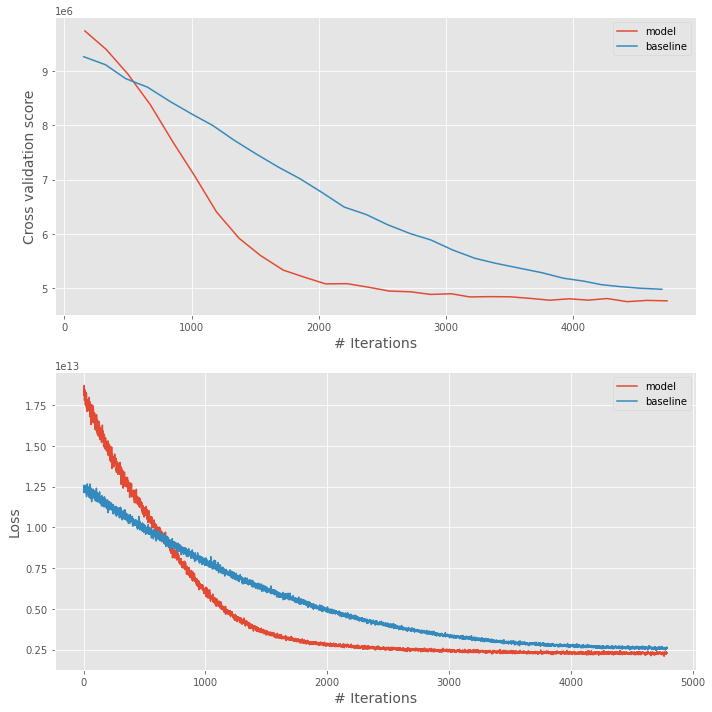

In [22]:
mmvec_paired_summary = summarize_paired(model_res.model_stats, null_res.model_stats)
mmvec_paired_summary.visualization.save('../results/mmvec/fecalall-microbe-model-summary.qzv')


In [52]:
model_res = paired_omics(table_metab, table_metag, metadata=q2.Metadata(metadata_metag_df),
                         training_column='mmvec_train_test_splits',
                         summary_interval=1, epochs=600)
null_res = paired_omics(table_metab, table_metag, metadata=q2.Metadata(metadata_metag_df),
                        training_column='mmvec_train_test_splits', latent_dim = 0,
                        summary_interval=1, epochs=600)


100%|██████████| 27168/27168 [00:27<00:00, 971.10it/s] 


In [53]:
model_res.conditionals.save('../results/mmvec/microbe-model-conditionals.qza')
model_res.conditional_biplot.save('../results/mmvec/microbe-model-biplot.qza')
model_res.model_stats.save('../results/mmvec/microbe-model-stats.qza')

'../results/mmvec/microbe-model-stats.qza'

In [54]:
null_res.conditionals.save('../results/mmvec/microbe-null-conditionals.qza')
null_res.conditional_biplot.save('../results/mmvec/microbe-null-biplot.qza')
null_res.model_stats.save('../results/mmvec/microbe-null-stats.qza')

'../results/mmvec/microbe-null-stats.qza'

'../results/mmvec/microbe-model-summary.qzv'

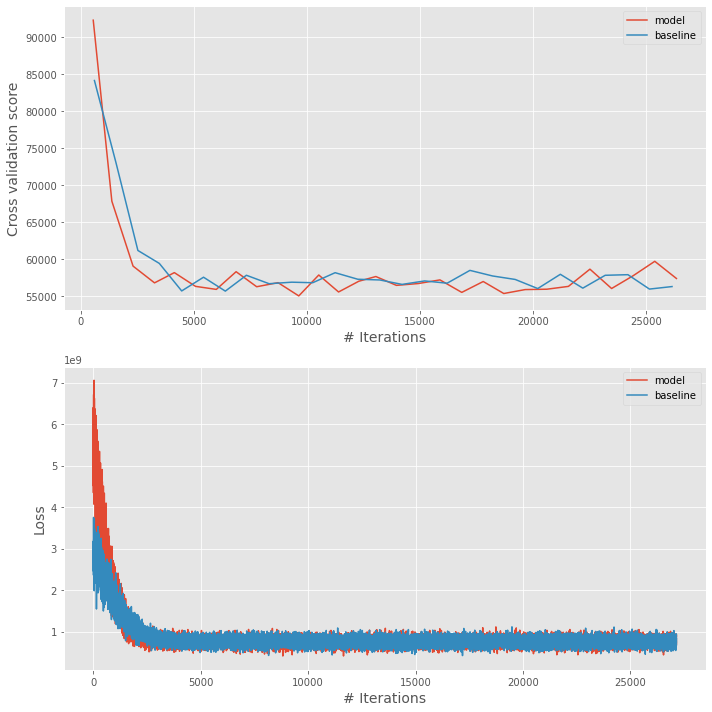

In [55]:
mmvec_paired_summary = summarize_paired(model_res.model_stats, null_res.model_stats)
mmvec_paired_summary.visualization.save('../results/mmvec/microbe-model-summary.qzv')


In [11]:
model_res = paired_omics(table_metag, table_metab, metadata=q2.Metadata(metadata_metag_df),
                         training_column='mmvec_train_test_splits',
                         summary_interval=1, epochs=2)
null_res = paired_omics(table_metag, table_metab, metadata=q2.Metadata(metadata_metag_df),
                        training_column='mmvec_train_test_splits', latent_dim = 0,
                        summary_interval=1, epochs=2)


100%|██████████| 657/657 [00:01<00:00, 606.92it/s]


In [12]:
model_res.conditionals.save('../results/mmvec/model-conditionals.qza')
model_res.conditional_biplot.save('../results/mmvec/model-biplot.qza')
model_res.model_stats.save('../results/mmvec/model-stats.qza')

'../results/mmvec/model-stats.qza'

In [13]:
null_res.conditionals.save('../results/mmvec/null-conditionals.qza')
null_res.conditional_biplot.save('../results/mmvec/null-biplot.qza')
null_res.model_stats.save('../results/mmvec/null-stats.qza')

'../results/mmvec/null-stats.qza'

'../results/mmvec/model-summary.qzv'

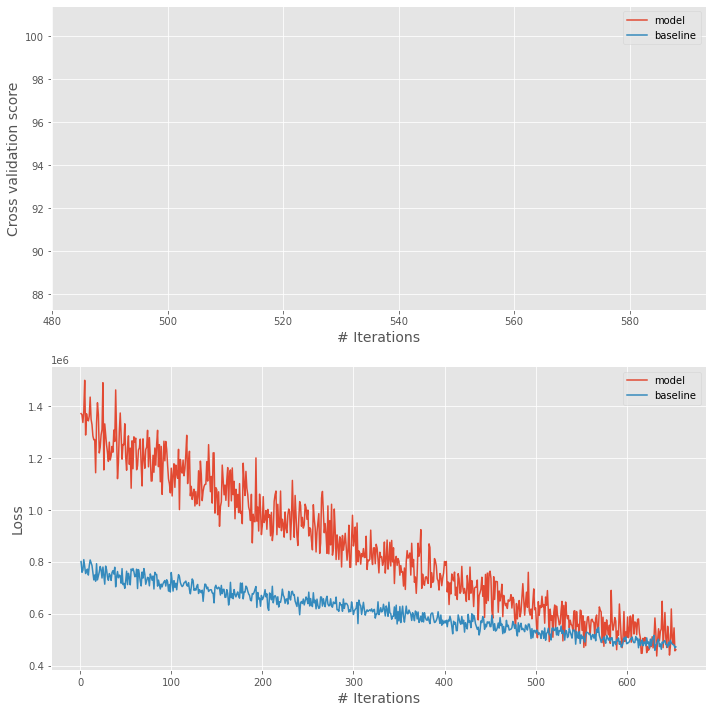

In [14]:
mmvec_paired_summary = summarize_paired(model_res.model_stats, null_res.model_stats)
mmvec_paired_summary.visualization.save('../results/mmvec/model-summary.qzv')
